In [1]:
import sys
sys.path.insert(0, '/home/niell_lab/Documents/github/FreelyMovingEphys/')
import pandas as pd
import xarray as xr
from utils.format_data import *
from utils.paths import find

In [2]:
import matplotlib.pyplot as plt

In [3]:
from pathlib import Path
import os

In [4]:
directory_path = '/home/niell_lab/data/object_avoidance/preliminary_data/recordings/'

In [5]:
##Load Data
# Dictionary of columns in data frame
data_dict = {'date': [],
             'animal': [],
             'task': [],             
             'poke1_ts':[],
             'poke2_ts': [],
#              'spout1_ts': [],
#              'spout2_ts': [],
             'top1_ts': [],
             'poke1_t0':[],
             'poke2_t0': [],
#              'spout1_t0': [],
#              'spout2_t0': [],
             'top1_t0': []}
# List of dates for analysis
dates= ['091321']
data_path = Path(directory_path).expanduser()
all_paths = []
#Populate Data Dict with meta data and timestamps   
for date in dates:
    for ani in os.listdir(data_path / date): 
        for task in os.listdir(data_path / date/ ani):
            data_paths = list((data_path / date/ ani/ task).rglob('*.csv'))
            if data_paths != []:
                data_dict['date'].append(data_paths[1].name.split('_')[0])
                data_dict['animal'].append(data_paths[1].name.split('_')[1])
                data_dict['task'].append(data_paths[1].name.split('_')[4])
            for ind, csv in enumerate(data_paths):
                data_dict[data_paths[ind].name.split('_')[5] +'_ts'].append(open_time(csv))
                data_dict[data_paths[ind].name.split('_')[5] +'_t0'].append(open_time(csv)[0])
df = pd.DataFrame.from_dict(data_dict)

In [6]:
df

,date,animal,task,poke1_ts,poke2_ts,top1_ts,poke1_t0,poke2_t0,top1_t0
0,091321,G6CK3LT,oa1,"[52934.298393, 52990.381491, 53016.777728, 530...","[52981.832192, 53005.578726, 53024.982963, 530...","[52933.193843, 52933.210176, 52933.226854, 529...",52934.298393,52981.832192,52933.193843
1,091321,G6CK3LT,oa,"[40616.381606, 40631.734707, 40650.458867, 406...","[40625.012492, 40644.019456, 40655.026278, 406...","[40615.302579, 40615.314419, 40615.331161, 406...",40616.381606,40625.012492,40615.302579
2,091321,G6CK3RT,oa1,"[54534.562009, 54550.152524, 54564.743756, 545...","[54546.506483, 54556.169894, 54569.24142, 5458...","[54533.468108, 54533.481203, 54533.49751, 5453...",54534.562009,54546.506483,54533.468108
3,091321,G6CK3RT,oa,"[39244.185574, 39278.754406, 39287.123302, 392...","[39273.736256, 39282.748403, 39292.11671, 3930...","[39243.078169, 39243.093222, 39243.109913, 392...",39244.185574,39273.736256,39243.078169


In [7]:
dlc_h5 = find('*.h5', directory_path)[2]
dlc_h5

'/home/niell_lab/data/object_avoidance/preliminary_data/recordings/091321/G6CK3RT/oa1/091321_G6CK3RT_control_Rig2_oa1_top1DLC_resnet50_object_avoidanceAug31shuffle1_200000.h5'

In [8]:
def filter_likelihood(da, thresh=0.99):
    x_cols = [i for i in da.columns.values if '_x' in i and 'arena' not in i]
    y_cols = [i for i in da.columns.values if '_y' in i]
    l_cols = [i for i in da.columns.values if '_likelihood' in i]
    for i in range(len(x_cols)):
        x = da.loc[:,x_cols[i]]; y = da.loc[:,y_cols[i]]; l = da.loc[:,l_cols[i]]
        x[l<thresh] = np.nan; y[l<thresh] = np.nan
        da.loc[:,x_cols[i]] = x; da.loc[:,y_cols[i]] = y
    return da

In [9]:
row =  df.iloc[2]
num_odd_trails = np.min([len(row['poke1_ts']), len(row['poke2_ts'])])
df1 = pd.DataFrame([])
dlc_positions_raw, dlc_labels = open_h5(dlc_h5)
dlc_positions = filter_likelihood(dlc_positions_raw)
count = -1
for c in range(num_odd_trails):
    # odd
    count += 1
    df1.at[count, 'first_poke'] = row['poke1_ts'][c]
    df1.at[count, 'second_poke'] = row['poke2_ts'][c]
    time = row['top1_ts']; time = time[time > df1.loc[count,'first_poke']]; time = time[time < df1.loc[count,'second_poke']]
    df1.at[count, 'trail_timestamps'] = time.astype(object)
    start_stop_inds = (int(np.where([row['top1_ts']==time[0]])[1]), int(np.where([row['top1_ts']==time[-1]])[1]))
    for pos in dlc_positions:
        df1.at[count, pos] = np.array(dlc_positions.loc[start_stop_inds[0]:start_stop_inds[1], pos]).astype(object)
    df1.at[count, 'len'] = start_stop_inds[1] - start_stop_inds[0]
    # even
    count += 1
    if c+1 < len(row['poke1_ts']):
        df1.at[count, 'first_poke'] = row['poke2_ts'][c]
        df1.at[count, 'second_poke'] = row['poke1_ts'][c+1]
        time = row['top1_ts']; time = time[time > df1.loc[count,'first_poke']]; time = time[time < df1.loc[count,'second_poke']]
        df1.at[count, 'trail_timestamps'] = time.astype(object)
        start_stop_inds = (int(np.where([row['top1_ts']==time[0]])[1]), int(np.where([row['top1_ts']==time[-1]])[1]))
        for pos in dlc_positions:
            df1.at[count, pos] = np.array(dlc_positions.loc[start_stop_inds[0]:start_stop_inds[1], pos]).astype(object)
        df1.at[count, 'len'] = start_stop_inds[1] - start_stop_inds[0]
df1['animal'] = row['animal']; df1['date'] = row['date']; df1['task'] = row['task']

In [24]:
dist_to_posts = np.median(df1['arenaTR_x'].iloc[0],0) - np.median(df1['arenaTL_x'].iloc[0],0)
pxls2cm = dist_to_posts/30.48

In [25]:
pxls2cm

17.778231966213916

In [1]:
pxls2cm = 17.778231966213916

In [3]:
592 / pxls2cm

33.299149270020095

In [126]:
for ind, row in df2.iterrows():
    df2.at[ind, 'speed'] = np.sqrt(list((np.diff(row['nose_x_cm'])/np.diff(row['trail_timestamps']))**2) + list((np.diff(row['nose_y_cm'])/np.diff(row['trail_timestamps']))**2)).astype(object)

In [94]:
def smooth_convolve(y, box_pts=10):
    """ Smooth values in an array using a convolutional window.

    Parameters:
    y (np.array): array to smooth
    box_pts (int): window size to use for convolution
    
    Returns
    y_smooth (np.array): smoothed y values
    """
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

Text(0, 0.5, 'cm/sec')

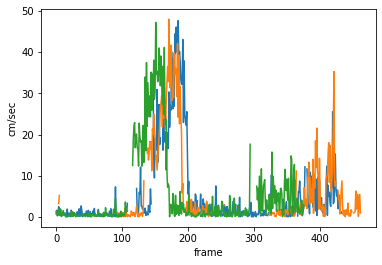

In [127]:
for i in range(5,8):
    plt.plot(df2['speed'].iloc[i])
plt.xlabel('frame')
plt.ylabel('cm/sec')

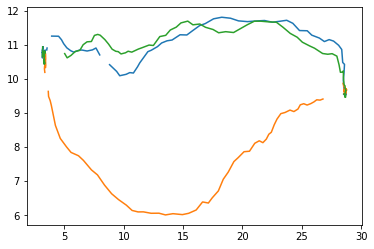

In [125]:
for a in range(5,8):
    plt.plot(df2['nose_x_cm'].iloc[a], df2['nose_y_cm'].iloc[a])

In [118]:
def convert_pxls_to_dist(da, pxls2cm):
    x_cols = [i for i in da.columns.values if '_x' in i and 'arena' not in i]
    y_cols = [i for i in da.columns.values if '_y' in i]
    for i in range(len(x_cols)):
        da[x_cols[i]+'_cm'] = da.loc[:,x_cols[i]]/pxls2cm
        da[y_cols[i]+'_cm'] = da.loc[:,y_cols[i]]/pxls2cm
    return da

In [119]:
df2 = convert_pxls_to_dist(df1, pxls2cm)

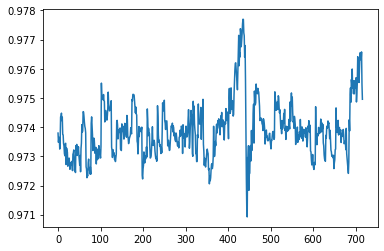

In [11]:
plt.plot(df1['arenaBR_likelihood'].iloc[0])

In [12]:
for ind, row in df1.iterrows():
    for x in ['b','w']:
        xvals = np.stack([row['obstacle'+x+'TL_x'], row['obstacle'+x+'TR_x'], row['obstacle'+x+'BL_x'], row['obstacle'+x+'BL_x']]).astype(float)
        df1.at[ind, x+'obstacle_x'] = np.nanmean(xvals)
        df1.at[ind, x+'obstacle_x_std'] = np.mean(np.nanstd(xvals, axis=1))
        yvals = np.stack([row['obstaclewTL_y'], row['obstaclewTR_y'], row['obstaclewBL_y'], row['obstaclewBL_y']]).astype(float)
        df1.at[ind, x+'obstacle_y'] = np.nanmean(yvals)
        df1.at[ind, x+'obstacle_y_std'] = np.mean(np.nanstd(yvals, axis=1))

/home/niell_lab/anaconda3/envs/DLC-GPU1/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


(array([131.,   9.,   5.,   0.,   1.,   2.,   2.,   1.,   1.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   1.]),
 array([ 176.  ,  257.64,  339.28,  420.92,  502.56,  584.2 ,  665.84,
         747.48,  829.12,  910.76,  992.4 , 1074.04, 1155.68, 1237.32,
        1318.96, 1400.6 , 1482.24, 1563.88, 1645.52, 1727.16, 1808.8 ,
        1890.44, 1972.08, 2053.72, 2135.36, 2217.  ]),
 <a list of 25 Patch objects>)

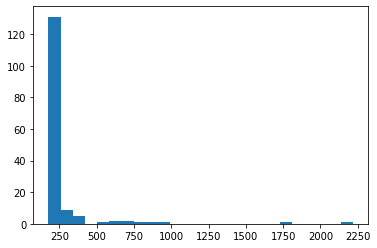

In [13]:
plt.hist(df1['len'], bins=25)

In [14]:
df1 = df1[df1['len']<300]
df1

,first_poke,second_poke,trail_timestamps,nose_x,nose_y,nose_likelihood,leftear_x,leftear_y,leftear_likelihood,rightear_x,...,date,task,bobstacle_x,bobstacle_x_std,bobstacle_y,bobstacle_y_std,wobstacle_x,wobstacle_x_std,wobstacle_y,wobstacle_y_std
1,54546.506483,54550.152524,"[54546.518745, 54546.535692, 54546.553715, 545...","[508.521240234375, 509.52569580078125, 508.689...","[170.7389678955078, 170.43377685546875, 170.67...","[0.9993851184844971, 0.9990812540054321, 0.998...","[474.169677734375, 476.06878662109375, 476.842...","[168.24232482910156, 167.85397338867188, 167.9...","[0.9998559951782227, 0.9997975826263428, 0.999...","[490.4239501953125, 492.1776123046875, 491.517...",...,091321,oa1,343.543568,134.367565,150.684086,0.402770,273.825936,NaN,150.684086,0.402770
4,54564.743756,54569.241420,"[54564.758054, 54564.775065, 54564.791513, 545...","[59.28833770751953, 59.00017166137695, 58.8556...","[188.36512756347656, 188.64283752441406, 188.1...","[0.9957120418548584, 0.9963630437850952, 0.996...","[85.06071472167969, 84.55770874023438, 83.8887...","[187.37356567382812, 186.99716186523438, 186.4...","[0.9999639987945557, 0.9999659061431885, 0.999...","[72.963623046875, 72.91352844238281, 72.787925...",...,091321,oa1,410.765950,102.406574,150.720349,0.793191,273.178340,NaN,150.720349,0.793191
7,54586.446016,54590.591462,"[54586.45111, 54586.46551, 54586.482099, 54586...","[511.7579345703125, 511.9116516113281, 511.713...","[173.29556274414062, 173.1143035888672, 173.72...","[0.999687671661377, 0.9996317625045776, 0.9995...","[483.55419921875, 483.4398498535156, 482.38677...","[161.46018981933594, 162.52371215820312, 163.2...","[0.999932050704956, 0.9999192953109741, 0.9999...","[484.8330078125, 485.1925048828125, 485.040130...",...,091321,oa1,347.361316,141.147037,150.529365,0.795923,273.857713,NaN,150.529365,0.795923
8,54590.591462,54593.876736,"[54590.600217, 54590.616857, 54590.633548, 545...","[59.80289077758789, 59.68534469604492, 59.4665...","[190.2515869140625, 189.78466796875, 189.36160...","[0.998357892036438, 0.9979526996612549, 0.9980...","[86.35167694091797, 85.71722412109375, 85.6759...","[188.02645874023438, 187.2926788330078, 187.09...","[0.9998998641967773, 0.9998962879180908, 0.999...","[76.59584045410156, 76.43264770507812, 76.4286...",...,091321,oa1,401.752251,108.720952,150.606633,0.686396,273.066621,NaN,150.606633,0.686396
9,54593.876736,54597.473228,"[54593.884595, 54593.901312, 54593.918489, 545...","[509.9363098144531, 509.0841369628906, 508.622...","[169.7750701904297, 168.722412109375, 169.4945...","[0.9968910813331604, 0.9978808164596558, 0.996...","[475.6702575683594, 476.22528076171875, 479.06...","[167.55758666992188, 166.4513702392578, 167.33...","[0.9995647668838501, 0.9991363286972046, 0.999...","[494.03546142578125, 493.81072998046875, 493.5...",...,091321,oa1,385.493108,105.790545,150.518366,0.542638,273.747453,NaN,150.518366,0.542638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,55156.527744,55160.489011,"[55156.543872, 55156.560588, 55156.578176, 551...","[513.6608276367188, 513.762451171875, 514.6018...","[177.66246032714844, 176.81979370117188, 176.9...","[0.9994211196899414, 0.9994221329689026, 0.999...","[490.4061584472656, 489.1361999511719, 489.064...","[159.7598876953125, 158.19239807128906, 155.76...","[0.9998689293861389, 0.9998749494552612, 0.999...","[480.34979248046875, 480.68157958984375, 480.8...",...,091321,oa1,254.246621,173.584315,166.050044,0.719219,364.447144,NaN,166.050044,0.719219
148,55160.489011,55164.097881,"[55160.496064, 55160.511872, 55160.528576, 551...","[58.70176315307617, 58.205718994140625, 58.738...","[191.0717315673828, 194.34246826171875, 194.18...","[0.9984011054039001, 0.9988560080528259, 0.998...","[85.49699401855469, 85.13862609863281, 84.6686...","[190.50320434570312, 189.89015197753906, 189.1...","[0.9999640583992004, 0.999977707862854, 0.9999...","[72.1750259399414, 70.05420684814453, 71.36499...",.

In [16]:
kmeans_input = np.stack([df1['wobstacle_x'].map(np.mean), df1['wobstacle_y'].map(np.mean)])
kmeans_input

array([[267.2178109 , 266.41645196, 267.29427339, 266.2923218 ,
        267.12299852, 266.25983457, 267.05885187, 266.24983329,
        267.17520614, 266.15362126, 267.1115617 , 266.04221032,
        267.21508037, 266.5388077 , 267.09473308, 266.0818819 ,
        267.19409252, 266.19340415, 267.15411513, 266.31647352,
        267.06817141, 266.4559773 , 267.04723649, 266.19007231,
        267.1274689 , 266.36713518, 267.10234348, 266.39508993,
        267.28925594, 266.46427788, 266.98756799, 266.28205876,
        267.07782183, 266.30282785, 267.12074908, 266.37505664,
        267.0901317 , 266.3627492 , 267.09501851, 266.17348948,
        267.08838139, 266.04658666, 267.81847151, 267.46518399,
        267.06544445, 266.28859046, 267.09500319, 266.292432  ,
        267.06576506, 266.13241466, 267.06192479, 266.65819085,
        267.12326465, 266.04866206, 160.67072358, 161.81397955,
        160.1066429 , 161.15636444, 160.3585213 , 162.20473767,
        160.26352506, 160.54606314, 159.

In [17]:
from sklearn.cluster import KMeans

In [18]:
labels = KMeans(n_clusters=3, random_state=0).fit(kmeans_input.T).labels_

In [19]:
df1['obstacle_cluster'] = labels

/home/niell_lab/anaconda3/envs/DLC-GPU1/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [20]:
import matplotlib.colors as mcolors

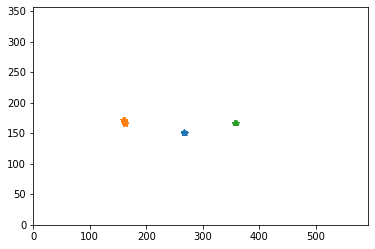

In [21]:
# plt.subplots(3,3,figsize=(9,9))
for i in range(len(labels)):
    label = labels[i]
    c = list(mcolors.TABLEAU_COLORS)[label]
    obstacles = kmeans_input[:,i]
#     plt.subplot(3,3,label+1)
    plt.plot(obstacles[0],obstacles[1],'*',color=c)
    plt.ylim([0,356]); plt.xlim([0,592])

In [193]:
for l in range(3):
    print(l, list(labels.flatten()).count(l))

0 59
1 65
2 31


100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 25.66it/s]


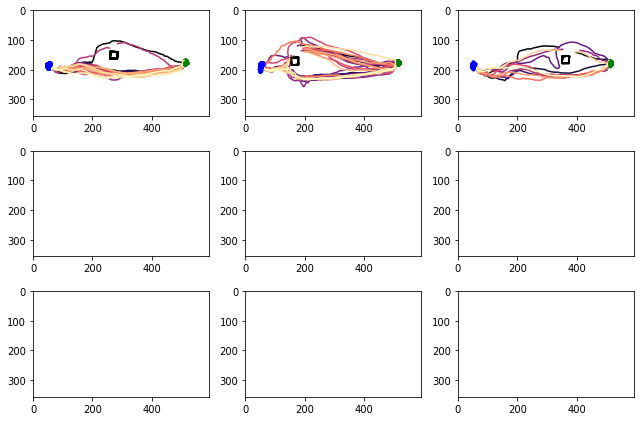

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 19.56it/s]


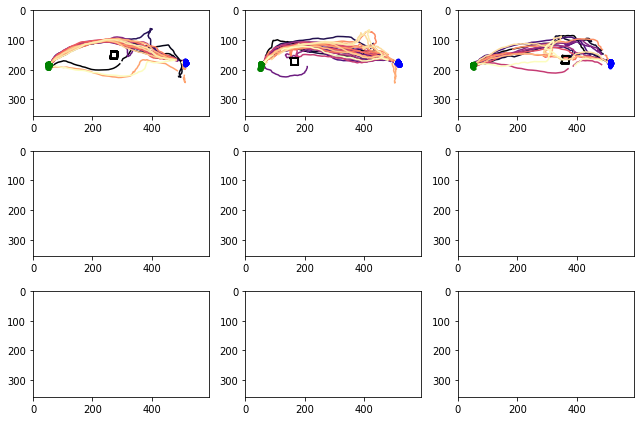

In [56]:
odd = df1[df1.index%2==0]
even = df1[df1.index%2==1]
direction_count = 0
for direction_df in [odd, even]:
    if direction_count == 0:
        leftcolor='g'; rightcolor='b'
    else:
        leftcolor='b'; rightcolor='g'
    plt.subplots(3,3,figsize=(9,6))
    for c in tqdm(range(9)):
        this_cluster = direction_df[direction_df['obstacle_cluster']==c].copy().reset_index()
        plt.subplot(3,3,c+1)
        plt.gca().set_aspect('equal', adjustable='box')
        colors = plt.cm.magma(np.linspace(0,1,len(this_cluster)))
        for ind, row in this_cluster.iterrows():
            plt.plot([np.median(row['obstaclewTL_x'],0),
                      np.median(row['obstaclewTR_x'],0),
                      np.median(row['obstaclewBR_x'],0),
                      np.median(row['obstaclewBL_x'],0),
                      np.median(row['obstaclewTL_x'],0)],
                     [np.median(row['obstaclewTL_y'],0),
                      np.median(row['obstaclewTR_y'],0),
                      np.median(row['obstaclewBR_y'],0),
                      np.median(row['obstaclewBL_y'],0),
                      np.median(row['obstaclewTL_y'],0)],'k-')
            plt.plot([np.median(row['arenaTL_x'],0),
                        np.median(row['arenaTR_x'],0),
                        np.median(row['arenaBR_x'],0),
                        np.median(row['arenaBL_x'],0),
                        np.median(row['arenaTL_x'],0)],
                        [np.median(row['arenaTL_y'],0),
                        np.median(row['arenaTR_y'],0),
                        np.median(row['arenaBR_y'],0),
                        np.median(row['arenaBL_y'],0),
                        np.median(row['arenaTL_y'],0)],'k-')
            plt.plot(row['nose_x'],row['nose_y'], '-', color=colors[ind])
            plt.plot(row['leftportT_x'], row['leftportT_y'],'.',color=leftcolor)
            plt.plot(row['rightportT_x'], row['rightportT_y'],'.',color=rightcolor)
        plt.ylim([356,0]); plt.xlim([0,592])
    direction_count += 1
    plt.tight_layout()
    plt.show()

In [65]:
row['nose_x'].tolist()

[509.8612365722656,
 508.243896484375,
 508.5342712402344,
 510.3333435058594,
 510.45745849609375,
 510.48175048828125,
 509.9639892578125,
 509.9219970703125,
 nan,
 nan,
 nan,
 509.0012512207031,
 509.7183837890625,
 509.96624755859375,
 nan,
 508.3998718261719,
 508.5962219238281,
 507.95654296875,
 508.26312255859375,
 nan,
 nan,
 nan,
 nan,
 508.2222900390625,
 nan,
 nan,
 nan,
 nan,
 nan,
 509.8148498535156,
 509.9554138183594,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 509.322021484375,
 nan,
 nan,
 nan,
 510.08343505859375,
 510.41204833984375,
 510.1670227050781,
 nan,
 nan,
 nan,
 nan,
 nan,
 509.6179504394531,
 nan,
 510.2076721191406,
 nan,
 nan,
 nan,
 510.06585693359375,
 510.07159423828125,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 510.34771728515625,
 510.42010498046875,
 510.48309326171875,
 nan,
 nan,
 510.5665588378906,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 509.68359375,
 nan,
 nan,
 nan,
 nan,
 nan,
 509.31781005859375,
 509.33331298828125,


In [2]:
import json
with open('/home/niell_lab/data/object_avoidance/recordings/oa_metadata.json') as f:    
    metadata = json.load(f)

In [5]:
list(metadata['recordings'].keys())

['090121', '090221', '090321', '090621', '090721', '090821', '091321']

In [6]:
metadata['recordings']['090221']

9